# 水蒸気ライダーデータの読み込み（1ファイル）

## 参考文献
* pandas | read_csv() 図解でわかりやすく解説！
  * https://www.yutaka-note.com/entry/pandas_read_csv
* pandas.read_table
  * https://pandas.pydata.org/docs/reference/api/pandas.read_table.html

In [291]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from pathlib import Path
import xarray as xr
import csv
import matplotlib.pyplot as plt

f = '../data/MRI_VAPOR/2021/07/09/23/Ko2107092345mgd.txt'
#f = '/Users/katon/Documents/NIED/SIP2/210924_SIP10月の評価会に向けての解析/data/MRI_VAPOR/2021/07/09/23/Ko2107092345mgd.txt'

pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_rows', 100)

In [292]:
print('== ヘッダーの前の2行の読み込み ==')
with open(f, 'r') as file:
    reader = csv.reader(file)#, delimiter=' ')
    header1 = reader.__next__()  # ヘッダーの読み込み
    header2 = reader.__next__()  # ヘッダーの読み込み
    print(header1)
    print(header2)

== ヘッダーの前の2行の読み込み ==
['2021/07/09 23:45:00-23:58:52 JST']
['fH2O= 62.19 /media/data/L0/Ko210709/23/Ko235800.(00-0d)25ns 24000/40bin dz149.90 7301 shot 0.300mrad wid=0 fnum:14 fnum_noise:0']


In [293]:
#---データの読み込み------------------------------------
#df = pd.read_table(f, sep='\s+', header=2, index_col=0)
df = pd.read_table(f, sep=' ', header=2, index_col=0)
  # sep=' ' : スペース区切り 
  # header=2: 0から数えて2行目をヘッダーとして読み込む
  # index_col=0: インデックスとして0列目を指定する（ここでは、"Altitude(km)"がインデックスとして指定される）
df

,W[g/kg],dW[g/kg],R355,dR355,T[K],RO[gm^-3],PZ^2_355,Wsonde[g/kg],dWsonde[g/kg]
Altitude(km),,,,,,,,,
0.19237,20.72,0.4304,-999.0,-1290.0,286.9,1.2020,4362.20400,0.0,0.0
0.26732,20.46,0.3619,-999.0,-1290.0,286.4,1.1940,27074.46000,0.0,0.0
0.34227,20.76,0.4611,-999.0,-1290.0,285.9,1.1850,33810.27000,0.0,0.0
0.41721,20.61,0.5324,-999.0,-1290.0,285.4,1.1760,21473.49000,0.0,0.0
0.49216,19.73,0.7561,-999.0,-1290.0,284.9,1.1680,25104.15000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
9.22362,-999.00,0.0000,-999.0,-1140.0,228.3,0.4545,42.54021,0.0,0.0
9.37351,-999.00,0.0000,-999.0,-1140.0,227.3,0.4463,43.93407,0.0,0.0
9.52341,-999.00,0.0000,-999.0,-1140.0,226.3,0.4382,45.35048,0.0,0.0


In [294]:
df.index

Float64Index([0.19237, 0.26732, 0.34227, 0.41721, 0.49216, 0.56711, 0.64206,
              0.71701, 0.79196,  0.8669, 0.94185,  1.0168, 1.12922, 1.27912,
              1.42901, 1.57891, 1.72881,  1.8787,  2.0286,  2.1785, 2.32839,
              2.47829, 2.62818, 2.77808, 2.92798, 3.07787, 3.22777, 3.37767,
              3.52756, 3.67746, 3.82735, 3.97725, 4.12715, 4.27704, 4.42694,
              4.57683, 4.72673, 4.87663, 5.02652, 5.17642, 5.32632, 5.47621,
              5.62611,   5.776,  5.9259,  6.0758, 6.22569, 6.37559, 6.52549,
              6.67538, 6.82528, 6.97517, 7.12507, 7.27497, 7.42486, 7.57476,
              7.72466, 7.87455, 8.02445, 8.17434, 8.32424, 8.47414, 8.62403,
              8.77393, 8.92383, 9.07372, 9.22362, 9.37351, 9.52341, 9.67331,
               9.8232],
             dtype='float64', name='Altitude(km)')

In [295]:
df.columns

Index(['W[g/kg]', 'dW[g/kg]', 'R355', 'dR355', 'T[K]', 'RO[gm^-3]', 'PZ^2_355',
       'Wsonde[g/kg]', 'dWsonde[g/kg]'],
      dtype='object')

In [296]:
#---解析: uncertainty(a)の算出、及びaを用いて品質管理した水蒸気混合比w2の算出（2つの変数はdfに格納する）
rmiss = np.nan
df = df.replace([-9.990000e+02], rmiss) # 欠損値-999.0をNANに置き換える
w  = df['W[g/kg]']
dw = df['dW[g/kg]']
a = dw/w * 100
df['uncertainty[%]'] = a
a_th = 30.0 # (%)
#rmiss = -999.0
df['W2[g/kg]'] = df['W[g/kg]'].mask(a>a_th, rmiss) # a が30%を超える場合、wにNANを入力しw2としてdfに格納
df
#df['W2[g/kg]'] 

,W[g/kg],dW[g/kg],R355,dR355,T[K],RO[gm^-3],PZ^2_355,Wsonde[g/kg],dWsonde[g/kg],uncertainty[%],W2[g/kg]
Altitude(km),,,,,,,,,,,
0.19237,20.72,0.4304,NaN,-1290.0,286.9,1.2020,4362.20400,0.0,0.0,2.077220,20.72
0.26732,20.46,0.3619,NaN,-1290.0,286.4,1.1940,27074.46000,0.0,0.0,1.768817,20.46
0.34227,20.76,0.4611,NaN,-1290.0,285.9,1.1850,33810.27000,0.0,0.0,2.221098,20.76
0.41721,20.61,0.5324,NaN,-1290.0,285.4,1.1760,21473.49000,0.0,0.0,2.583212,20.61
0.49216,19.73,0.7561,NaN,-1290.0,284.9,1.1680,25104.15000,0.0,0.0,3.832235,19.73
...,...,...,...,...,...,...,...,...,...,...,...
9.22362,NaN,0.0000,NaN,-1140.0,228.3,0.4545,42.54021,0.0,0.0,NaN,NaN
9.37351,NaN,0.0000,NaN,-1140.0,227.3,0.4463,43.93407,0.0,0.0,NaN,NaN
9.52341,NaN,0.0000,NaN,-1140.0,226.3,0.4382,45.35048,0.0,0.0,NaN,NaN


<AxesSubplot:xlabel='Altitude(km)'>

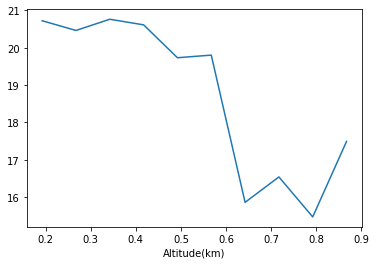

In [297]:
df["W2[g/kg]"].plot()#.line(y="Altitude(km)", color='black', marker='o')#, m

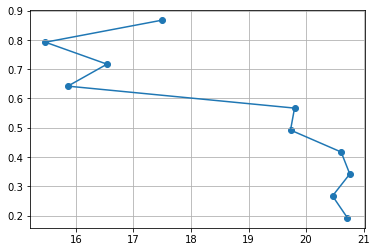

In [304]:
x = df.index
y = df["W2[g/kg]"]
ax = plt.subplot()
ax.scatter(y, x)
ax.plot(y, x)
ax.grid(True)

In [305]:
#df.mask(df['W2[g/kg]']<0.0)
#df.mask(df['W2[g/kg]']<0.0).describe()
df.describe()

,W[g/kg],dW[g/kg],R355,dR355,T[K],RO[gm^-3],PZ^2_355,Wsonde[g/kg],dWsonde[g/kg],uncertainty[%],W2[g/kg]
count,1.700000e+01,7.100000e+01,0.0,71.000000,71.000000,71.000000,71.000000,71.0,71.0,1.700000e+01,10.000000
mean,1.409118e+101,3.373944e+200,NaN,-1104.055070,257.922535,0.793680,1950.317237,0.0,0.0,1.764706e+101,18.744000
std,3.369956e+101,inf,NaN,178.505942,19.345883,0.245302,6424.544095,0.0,0.0,3.929526e+101,2.158946
min,4.928000e+00,-9.990000e+11,NaN,-1290.000000,224.400000,0.422500,0.000000,0.0,0.0,1.768817e+00,15.470000
25%,1.654000e+01,0.000000e+00,NaN,-1194.000000,241.400000,0.576600,9.023633,0.0,0.0,3.832235e+00,16.777500
50%,2.046000e+01,0.000000e+00,NaN,-1140.000000,258.400000,0.770400,20.838130,0.0,0.0,1.839690e+01,19.765000
75%,1.187000e+02,0.000000e+00,NaN,-1041.000000,275.450000,1.011500,46.069925,0.0,0.0,2.644482e+02,20.572500
max,1.200000e+102,1.200000e+202,NaN,-13.110000,286.900000,1.202000,33810.270000,0.0,0.0,1.000000e+102,20.760000


In [306]:
xr = df.to_xarray()
xr

<xarray.Dataset>
Dimensions:         (Altitude(km): 71)
Coordinates:
  * Altitude(km)    (Altitude(km)) float64 0.1924 0.2673 0.3423 ... 9.673 9.823
Data variables:
    W[g/kg]         (Altitude(km)) float64 20.72 20.46 20.76 ... nan nan nan
    dW[g/kg]        (Altitude(km)) float64 0.4304 0.3619 0.4611 ... 0.0 0.0 0.0
    R355            (Altitude(km)) float64 nan nan nan nan ... nan nan nan nan
    dR355           (Altitude(km)) float64 -1.29e+03 -1.29e+03 ... -1.194e+03
    T[K]            (Altitude(km)) float64 286.9 286.4 285.9 ... 225.3 224.4
    RO[gm^-3]       (Altitude(km)) float64 1.202 1.194 1.185 ... 0.4303 0.4225
    PZ^2_355        (Altitude(km)) float64 4.362e+03 2.707e+04 ... 46.79 0.0
    Wsonde[g/kg]    (Altitude(km)) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dWsonde[g/kg]   (Altitude(km)) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    uncertainty[%]  (Altitude(km)) float64 2.077 1.769 2.221 ... nan nan nan
    W2[g/kg]        (Altitude(km)) float64 20.72 20.46 20.76 ... nan nan nan

In [307]:
xr.assign_coords(time=pd.to_datetime("202107092345"))

<xarray.Dataset>
Dimensions:         (Altitude(km): 71)
Coordinates:
  * Altitude(km)    (Altitude(km)) float64 0.1924 0.2673 0.3423 ... 9.673 9.823
    time            datetime64[ns] 2021-07-09T23:45:00
Data variables:
    W[g/kg]         (Altitude(km)) float64 20.72 20.46 20.76 ... nan nan nan
    dW[g/kg]        (Altitude(km)) float64 0.4304 0.3619 0.4611 ... 0.0 0.0 0.0
    R355            (Altitude(km)) float64 nan nan nan nan ... nan nan nan nan
    dR355           (Altitude(km)) float64 -1.29e+03 -1.29e+03 ... -1.194e+03
    T[K]            (Altitude(km)) float64 286.9 286.4 285.9 ... 225.3 224.4
    RO[gm^-3]       (Altitude(km)) float64 1.202 1.194 1.185 ... 0.4303 0.4225
    PZ^2_355        (Altitude(km)) float64 4.362e+03 2.707e+04 ... 46.79 0.0
    Wsonde[g/kg]    (Altitude(km)) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dWsonde[g/kg]   (Altitude(km)) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    uncertainty[%]  (Altitude(km)) float64 2.077 1.769 2.221 ... nan nan nan
    W2[g/kg]        (Altitude(km)) float64 20.72 20.46 20.76 ... nan nan nan

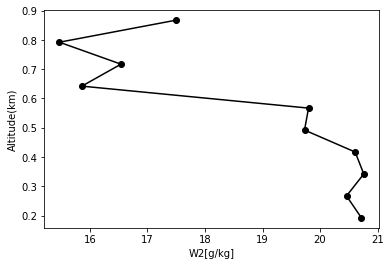

In [308]:
xr["W2[g/kg]"].plot.line(y="Altitude(km)", color='black', marker='o')#, ms=2)